In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
# Declare a Base using 'automap_base'
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

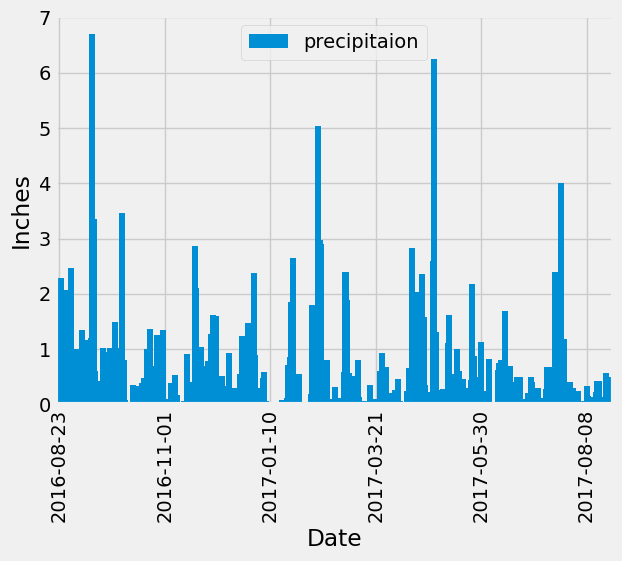

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
sel = [measurement.date, 
       func.max(measurement.prcp)]
historical_prcp = session.query(*sel).\
    group_by(measurement.date).\
    filter(measurement.date>= year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(historical_prcp, columns=['Date', 'precipitaion'])

# Sort the dataframe by date
sorted_df = df.sort_values(by = ['Date'])

# Use Pandas Plotting with Matplotlib to plot the data
sorted_df.set_index('Date', inplace=True)
sorted_df.plot.bar(width=4)
plt.ylabel("Inches")
plt.xticks(np.arange(0, 366, step=70))
plt.tight_layout
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
sel = [measurement.date, measurement.prcp]
historical_prcp = session.query(*sel).\
    filter(measurement.date>= year_ago).all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(historical_prcp, columns=['Date', 'precipitaion'])
df.describe()

,precipitaion
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(station.station)).all()

[(9,)]

In [13]:
# Get a list of columns from measurement table
inspector = inspect(engine)
measurement_cols = inspector.get_columns('measurement')
for c in measurement_cols:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [14]:
# Get a list of columns from station table
station_cols = inspector.get_columns('station')
for c in station_cols:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
sel = [measurement.station,
       func.count(measurement.tobs)]
active_stations = session.query(*sel)\
    .join(station, station.station == measurement.station)\
    .group_by(measurement.station)\
    .order_by(func.count(measurement.tobs).desc())\
    .all()
# List the stations and their counts in descending order.
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

### Station USC00519281 has the greatest number of observations.

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)]
most_active_tobs = session.query(*sel)\
    .filter(measurement.station == "USC00519281").all()
most_active_tobs

[(54.0, 85.0, 71.66378066378067)]

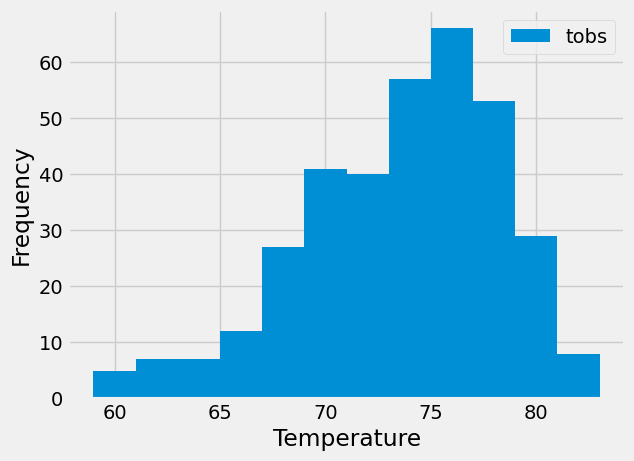

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [measurement.tobs]
historical_tobs = session.query(*sel)\
    .filter(measurement.date>= year_ago)\
    .filter(measurement.station== "USC00519281")\
    .all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
tobs_df = pd.DataFrame(historical_tobs)

# Create the histogram
tobs_df.plot(kind="hist", bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close Session

In [18]:
# Close Session
session.close()